# Computations
This notebook is to review and compare computation performance for each scenario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# take the long one to get a baseline
LONG = r'output_logs/211026104226'
SHORT120 = r'output_logs/211027170646'
SHORT180 = r'output_logs/211027145449'
SHORT240 = r'output_logs/211027070856'

comp_log_folders = [LONG,SHORT120,SHORT180,SHORT240]
comp_logs = dict()
comp_labels = ['long','120','180','240']
for lbl,folder in zip(comp_labels,comp_log_folders):
    
    print(lbl)
    df = pd.read_csv(os.path.join(folder,'computation_log.csv'))
    df.columns = [col.replace("_"," ") for col in df.columns]
    
    comp_logs[lbl] = df
    

long
120
180
240


In [2]:
# gather all of the times in the dfs
time_cols = [col for col in comp_logs['240'] if "time" in col]
time_cols

['state update time',
 'rv compute time',
 'rtv compute time',
 'greedy time',
 'data gen time',
 'main ilp time',
 'booking time',
 'bal ilp time',
 'rebalance booking time']

In [3]:
time_data = pd.concat([comp_logs[lbl].loc[:,['t','MaxWait']+time_cols] 
                       for lbl in ['120','180','240']],ignore_index=True)
time_data.head()

MINT = time_data['t'].min()
MAXT = time_data['t'].max()
print(MINT,MAXT)

500430 507600



120
state update time         6.759693
rv compute time           8.581058
rtv compute time          2.576427
greedy time               0.069144
data gen time             0.011189
main ilp time             0.098147
booking time              2.446564
bal ilp time              0.188645
rebalance booking time    0.620209
dtype: float64

180
state update time          6.685036
rv compute time           10.743000
rtv compute time          10.901204
greedy time                0.299601
data gen time              0.027380
main ilp time              0.350372
booking time               3.781893
bal ilp time               0.105060
rebalance booking time     0.283776
dtype: float64

240
state update time          6.669538
rv compute time           14.150482
rtv compute time          85.432101
greedy time                0.874648
data gen time              0.073084
main ilp time              1.476107
booking time               4.779705
bal ilp time               0.038150
rebalance booking time     0

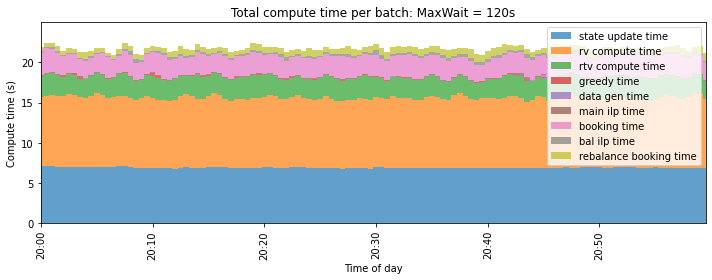

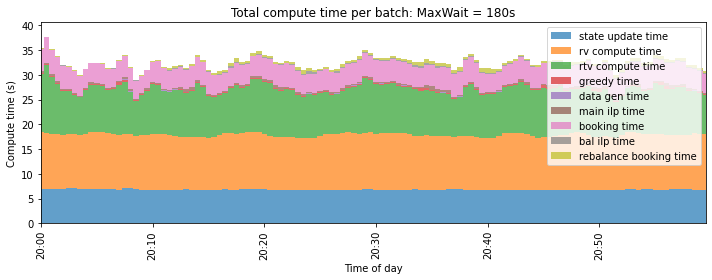

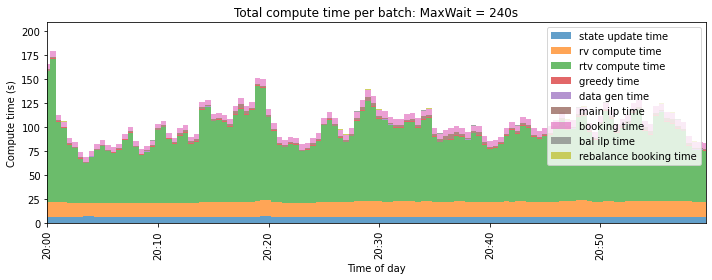

In [4]:
# create some ticks for all time
bounds = [0,239]
make_label = lambda x: f"{x//(120)%24+19}:{x//(2)%60:02.0f}"
sec_ticks = np.arange(0,240,20)
st_labels = [make_label(tick) for tick in sec_ticks]


for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(10,4))
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,time_cols].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
    
    # print the mean values
    print()
    print(MW)
    print(data.loc[:,time_cols].mean(axis=0))
    
    ax.set_xticks(sec_ticks)
    ax.set_xticklabels(st_labels)
    ax.set_title(f"Total compute time per batch: MaxWait = {MW}s")
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Compute time (s)")
    plt.legend(loc='upper right')
    plt.xlim([120,239])
    
    # get max time
    max_time = data.loc[data['t']>MINT+3600,time_cols].sum(axis=1).max()
    plt.ylim([0,max_time*1.05])
    plt.tight_layout()
    plt.savefig(f"results/compute_times_{MW}.jpg")
                          
                          

While the RTV / RV are slow, they could do with some algorithmic improvements, the RTV implementation may be parallelized over cliques to compute feasible trips - and it's easy to reason the an entity with the capital to support a fleet of autonomous vehicles could afford a descent cluster to speed up compared to my (Rob) 4 core laptop.

Why is the ILP so fast?


In [5]:
# plot the number of constraints and variables over time
ilp_cols = [col for col in comp_logs['240'] if "ilp" in col]

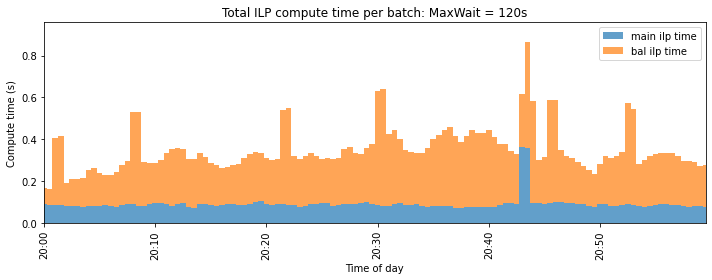

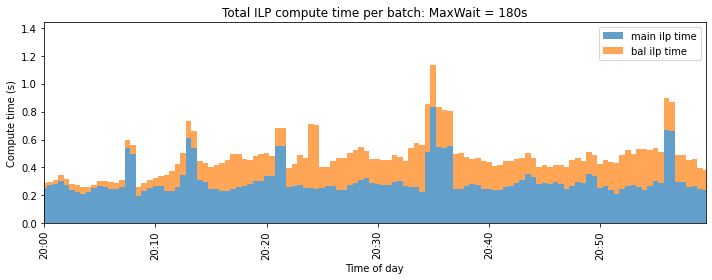

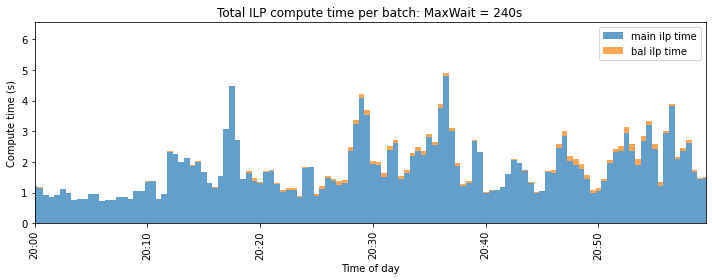

In [6]:
# just the ILP times
for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(10,4))
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,['main ilp time','bal ilp time']].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
            
    ax.set_xticks(sec_ticks)
    ax.set_xticklabels(st_labels)    
    ax.set_title(f"Total ILP compute time per batch: MaxWait = {MW}s")
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Compute time (s)")
    plt.legend(loc='upper right')
    plt.xlim([120,239])
    
    # get max time
    max_time = data.loc[data['t']>MINT+3600,['main ilp time','bal ilp time']].sum(axis=1).max()
    plt.ylim([0,max_time*1.05])
    plt.tight_layout()
    plt.savefig(f"results/ilp_time_{MW}.jpg")


120
t                         504015.000000
num new requests             221.920833
num current requests         661.183333
state update time              6.759693
rv compute time                8.581058
num rv edges                2765.925000
rtv compute time               2.576427
num rtv edges               3188.216667
greedy time                    0.069144
data gen time                  0.011189
num main ilp vars           2968.775000
num main ilp constr         1924.858333
main ilp time                  0.098147
num trips                    355.000000
booking time                   2.446564
num bal ilp vars            6634.325000
num bal ilp constr           250.095833
bal ilp time                   0.188645
num rebalanced                53.220833
rebalance booking time         0.620209
MaxWait                      120.000000
dtype: float64

180
t                         504015.000000
num new requests             221.920833
num current requests         776.000000
state update ti

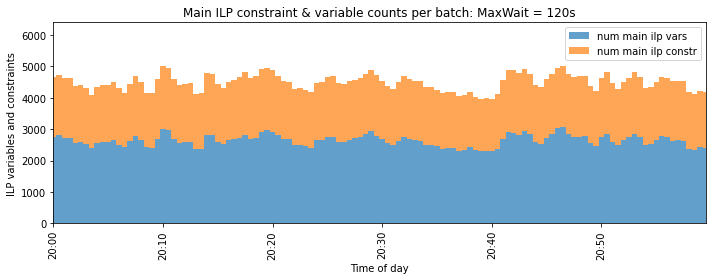

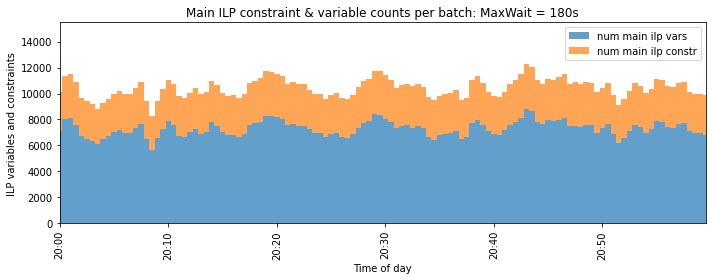

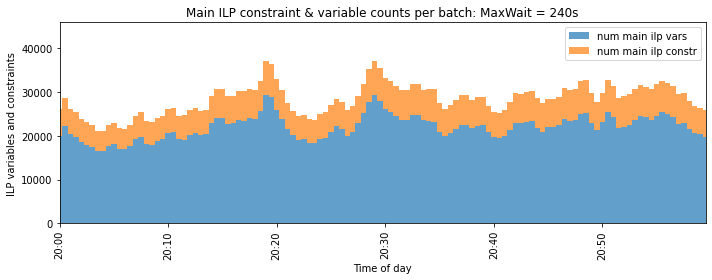

In [8]:
# plot the number of variables and constraints
# just the ILP times
for MW,data in time_data.groupby(['MaxWait']):
    
    fig,ax = plt.subplots(figsize=(10,4))
    data = comp_logs[str(MW)]
    data.set_index(['t']).\
        rolling(2).mean().\
        loc[:,['num main ilp vars','num main ilp constr']].\
        plot(kind='bar',stacked=True,ax=ax,width=1,alpha=0.7)
    
    
    
    print()
    print(MW)
    print(data.mean(axis=0))
            
    ax.set_xticks(sec_ticks)
    ax.set_xticklabels(st_labels)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("ILP variables and constraints")
    plt.legend(loc='upper right')
    plt.xlim([120,239])
    
    # get max time
    max_objs = data.loc[data['t']>MINT+3600,['num main ilp vars','num main ilp constr']].sum(axis=1).max()
    ax.set_title(f"Main ILP constraint & variable counts per batch: MaxWait = {MW}s")
    plt.ylim([0,max_objs*1.05])
    plt.tight_layout()
    plt.savefig(f"results/ilp_objs_{MW}.jpg")

Number of variables decrease once cabs are utilised. Show this. Show utilisation by time interval for each scenario.
